# **Graded Challenge 7**
---

# **1. Introduction**

- **Name:** Wilson

- **Batch:** HCK-016

- **Objective:** This program is made to do sentiment analysis on steam reviews

- **Dataset overview:** Our data contains information about steam game reviews 

# **2. Import Libraries**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# feature engineering
from tensorflow.keras.layers import Embedding
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# model definition & training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, TextVectorization

# model evaluation
from sklearn import metrics

# save model
import pickle
import json

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.set_option('display.max_columns', None)

# **3. Data Loading**

## **3.1. Load Data**

- We load our trimmed data for faster train time and to meet the time and computational limitation that we're facing

In [2]:
# load table 
df_raw = pd.read_csv('train_trimmed.csv')

# only take relevant columns
df_raw = df_raw[['user_review', 'user_suggestion']]

## **3.2. Basic Data Exploration**

- **Insight:**
    - There are `no missing value` in our data
    - Column `user_review` needs to be preprocessed
    - There are some duplicated values in `user_review`

**Show Samples of Data**

In [3]:
display(df_raw.head(5))
display(df_raw.tail(5))

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


,user_review,user_suggestion
4995,This game is really fun. Although many people ...,1
4996,This game is LEGIT amazing. 2 things tho1. Mak...,1
4997,The game mechanics and ranking is completely b...,0
4998,if you say this is bad then you stink bc this ...,1
4999,Early Access ReviewFrom what i've played so fa...,1


**Show Basic Info**

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_review      5000 non-null   object
 1   user_suggestion  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


**Check for Duplicates**

In [5]:
df_raw[df_raw['user_review'].duplicated()]

,user_review,user_suggestion
2702,#NAME?,0


## **3.3. Drop Duplicated Values**

In [6]:
df_raw.drop_duplicates(inplace=True)

# **4. Exploratory Data Analysis**

## *4.1. What is the balance ratio between the target?*

- **Insight:**
     - `32.7%` for `not_recommended` 
     - `67.3%` for `recommended`
     - our data is quite imbalanced 

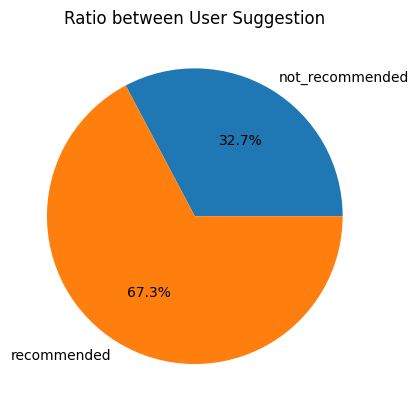

In [7]:
# make a copy of df
df_eda_1 = df_raw.copy()

# group df by user_suggestion and count user_review
df_eda_1_grouped = pd.DataFrame(df_eda_1.groupby(by='user_suggestion')['user_review'].count()).reset_index()
df_eda_1_grouped.rename(columns={'user_review' : 'amount'}, inplace=True)

# set plot's title
plt.title('Ratio between User Suggestion')

# define plot
plt.pie(data=df_eda_1_grouped, x='amount', labels=['not_recommended', 'recommended'], autopct='%1.1f%%')

# show plot
plt.show()

## *4.2. How is the data distribution of user_review's word count?*

- **Insight:**
     - The data distribution of user_review's word count is highly positively skewed (outliers on the right side)

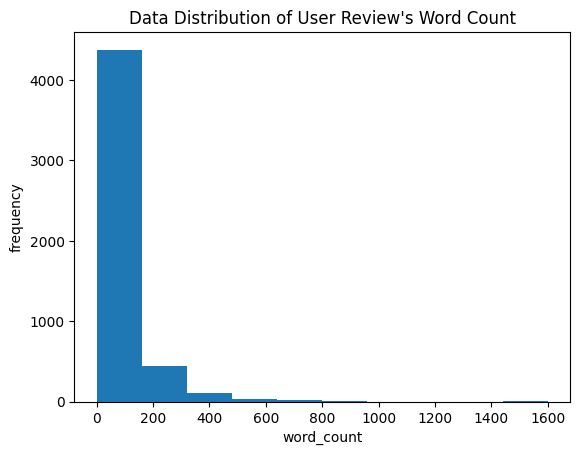

In [8]:
# make a copy of df
df_eda_2 = df_raw.copy()

# define stopword & punctuation
nltk_stopword = set(stopwords.words('english'))
str_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# split
words = df_eda_2['user_review'].str.split(' ')

# remove stopword & punctuation
words_no_sp = []
for w in words:
    temp = []
    for i in w:
        if (i not in nltk_stopword) and (i not in str_punctuation):
            temp.append(i)
    words_no_sp.append(temp)

# get word count
word_counts = []
for w in words_no_sp:
    word_counts.append(len(w))

# draw plot
plt.hist(x=word_counts)

# set title
plt.title('Data Distribution of User Review\'s Word Count')

# set label
plt.xlabel('word_count')
plt.ylabel('frequency')

# show plot
plt.show()

## *4.3. What are the words that are associated with recommended user_suggestion?*

- **Insight:**
     - Some words that's associated with recomended user_suggestion that take up a lot of space in our wordcloud are 'game', 'NOPE', 'play', 'early', 'access'

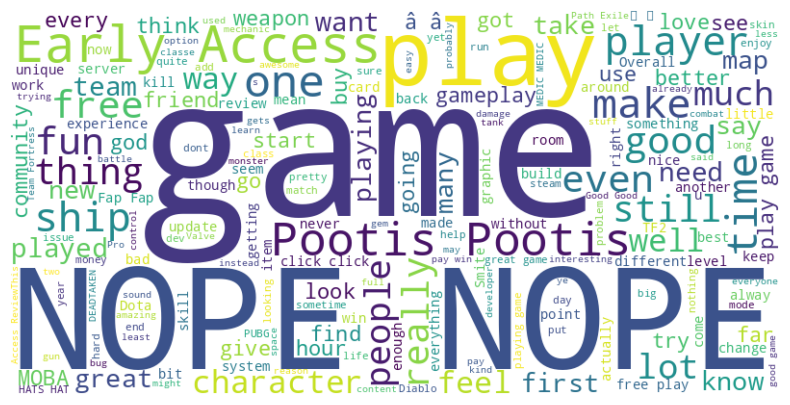

In [9]:
# copy df
df_eda_3 = df_raw.copy()

# add words
df_eda_3['words'] = words_no_sp

# get words in recommended rows
words_in_rec = df_eda_3[df_eda_3['user_suggestion'] == 1]['words']

# combine text
flat_text = []
for w in words_in_rec:
    flat_text += w

combined_text = ' '.join(flat_text)

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **5. Feature Engineering**

## **5.1. Feature Splitting**

- We split our data into features and target, with the ratio of `75 train : 25 test`, then we split our train again into `80 train : 20 validation`

In [10]:
# split X and y
X = df_raw['user_review']
y = df_raw['user_suggestion']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 7, stratify=y_train)

## **5.2. Text Preprocessing**

- We turn our sentences into tokens, removing unnecessary characters such as stop words, punctuation, symbols, etc. 

In [11]:
# copy data
X_train_tpre = X_train.copy()
X_val_tpre = X_val.copy()
X_test_tpre = X_test.copy()

In [12]:
# define stopwords
nltk_stopword = set(stopwords.words('english'))

# define lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
# create a function for text preprocessing

def text_preprocessing(text):
  # case folding
  text = text.lower()

  # mention removal
  text = re.sub("@[a-za-z0-9_]+", " ", text)

  # hashtags removal
  text = re.sub("#[a-za-z0-9_]+", " ", text)

  # newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # whitespace removal
  text = text.strip()

  # url removal
  text = re.sub(r"http\s+", " ", text)
  text = re.sub(r"www.\s+", " ", text)

  # non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^a-za-z\s']", " ", text)
  text = re.sub("'", "", text)

  # tokenization
  tokens = word_tokenize(text)

  # stopwords removal
  tokens = [word for word in tokens if word not in nltk_stopword]

  # lemmatizing
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # combining tokens
  text = ' '.join(tokens)

  return text

In [14]:
# Applying Text Preprocessing to the Dataset
X_train_tpre = X_train_tpre.apply(lambda x: text_preprocessing(x))
X_val_tpre = X_val_tpre.apply(lambda x: text_preprocessing(x))
X_test_tpre = X_test_tpre.apply(lambda x: text_preprocessing(x))

X_train_tpre.head(5)

3036    blast game couple year ive played know hour do...
1873    gone hell also utterly wasted k hour could wou...
4128    first started playing game smartphone month ag...
220     first played game bit confused work play slowl...
4782    pro moba give shoulder view wasd movement rath...
Name: user_review, dtype: object

## **5.3. Text Vectorization**

- We turn our tokens into vectors, so that our model can process them

In [15]:
# use CountVectorizer to get total vocab and max sentence length
vectorzier = CountVectorizer()

X_train_vect = vectorzier.fit_transform(X_train_tpre)
X_val_vect = vectorzier.transform(X_val_tpre)
X_test_vect = vectorzier.transform(X_test_tpre)

In [16]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(vectorzier.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  17384
Maximum Sentence Length :  1600 tokens


In [17]:
text_vectorization = TextVectorization(max_tokens=10_000, # we limit this to get faster train time & better generalization
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train_tpre)

X_train_vect = text_vectorization(X_train_tpre)
X_val_vect = text_vectorization(X_val_tpre)
X_test_vect = text_vectorization(X_test_tpre)

## **5.1. Word Embedding**

- We embed our vectors to make them more compact

In [18]:
# Embedding

embedding = Embedding(input_dim=10_000, # we limit this to get faster train time & better generalization
                      output_dim=128,
                      embeddings_initializer="uniform")

# **6. ANN Training**

## **6.1. Model Defintion**

### **6.1.1. LSTM**

- **Strengths:**
    - Relatively accurate and powerful
    - Able to capture and preserve information for longer
- **Weaknesses:**
    - Prone to overfitting
    - Requires some effort to find the optimal hyperparameters

In [85]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dense(1, activation='sigmoid'))

model_lstm_1.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), optimizer='adam', metrics='accuracy')

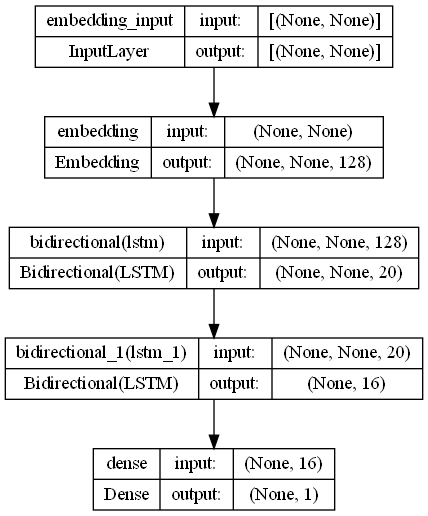

In [86]:
# plot layers
tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

### **6.1.2. GRU**

- **Strengths:**
    - Relatively simple
    - Faster to train and run
- **Weaknesses:**
    - Less powerful to capture complex relationships

In [87]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_gru_1 = Sequential()
model_gru_1.add(embedding)
model_gru_1.add(Bidirectional(GRU(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_1.add(Bidirectional(GRU(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru_1.add(Dense(1, activation='sigmoid'))

model_gru_1.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), optimizer='adam', metrics='accuracy')

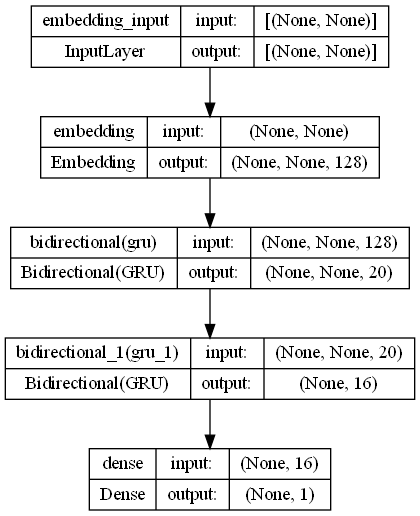

In [88]:
# plot layers
tf.keras.utils.plot_model(model_gru_1, show_shapes=True)

## **6.2. Model Training**

### **6.2.1. LSTM**

- We use early stopping callback to not waste our time when there's no improvement as the epoch progresses

In [89]:
# add earlystopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=8, restore_best_weights=True)

model_lstm_1_hist = model_lstm_1.fit(X_train_vect, y_train, epochs=25, validation_data=(X_val_vect, y_val), callbacks=[early_stopping])

Epoch 1/25
88/88 [==============================] - 24s 228ms/step - loss: 0.0658 - accuracy: 0.9139 - val_loss: 0.1418 - val_accuracy: 0.8049
Epoch 2/25
88/88 [==============================] - 19s 218ms/step - loss: 0.0076 - accuracy: 0.9964 - val_loss: 0.2285 - val_accuracy: 0.7996
Epoch 3/25
88/88 [==============================] - 19s 217ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.2781 - val_accuracy: 0.7974
Epoch 4/25
88/88 [==============================] - 19s 218ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3103 - val_accuracy: 0.7996
Epoch 5/25
88/88 [==============================] - 19s 218ms/step - loss: 6.8986e-04 - accuracy: 1.0000 - val_loss: 0.3421 - val_accuracy: 0.7996
Epoch 6/25
88/88 [==============================] - 19s 218ms/step - loss: 4.8317e-04 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.7996
Epoch 7/25
88/88 [==============================] - 19s 217ms/step - loss: 3.6095e-04 - accuracy: 1.0000 - val_loss: 0.3816 - val_accu

### **6.2.2. GRU**

In [90]:
model_gru_1_hist = model_gru_1.fit(X_train_vect, y_train, epochs=25, validation_data=(X_val_vect, y_val), callbacks=[early_stopping])

Epoch 1/25
88/88 [==============================] - 21s 197ms/step - loss: 0.0947 - accuracy: 0.8414 - val_loss: 0.1395 - val_accuracy: 0.7740
Epoch 2/25
88/88 [==============================] - 16s 187ms/step - loss: 0.0123 - accuracy: 0.9858 - val_loss: 0.2305 - val_accuracy: 0.8092
Epoch 3/25
88/88 [==============================] - 16s 188ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.2590 - val_accuracy: 0.8134
Epoch 4/25
88/88 [==============================] - 17s 188ms/step - loss: 4.8504e-04 - accuracy: 1.0000 - val_loss: 0.2894 - val_accuracy: 0.8092
Epoch 5/25
88/88 [==============================] - 17s 188ms/step - loss: 2.9499e-04 - accuracy: 1.0000 - val_loss: 0.3136 - val_accuracy: 0.8049
Epoch 6/25
88/88 [==============================] - 17s 188ms/step - loss: 2.0235e-04 - accuracy: 1.0000 - val_loss: 0.3336 - val_accuracy: 0.8060
Epoch 7/25
88/88 [==============================] - 16s 188ms/step - loss: 1.4961e-04 - accuracy: 1.0000 - val_loss: 0.3513 - val_

## **6.3. Model Evaluation**

### **6.3.1. LSTM** 

- Our model is a quite overfitting to our train set, as we can see from the gap between train and val lines
- The model's accuracy stopped improving after epoch 2
- The model's loss got worse as the epoch progressed

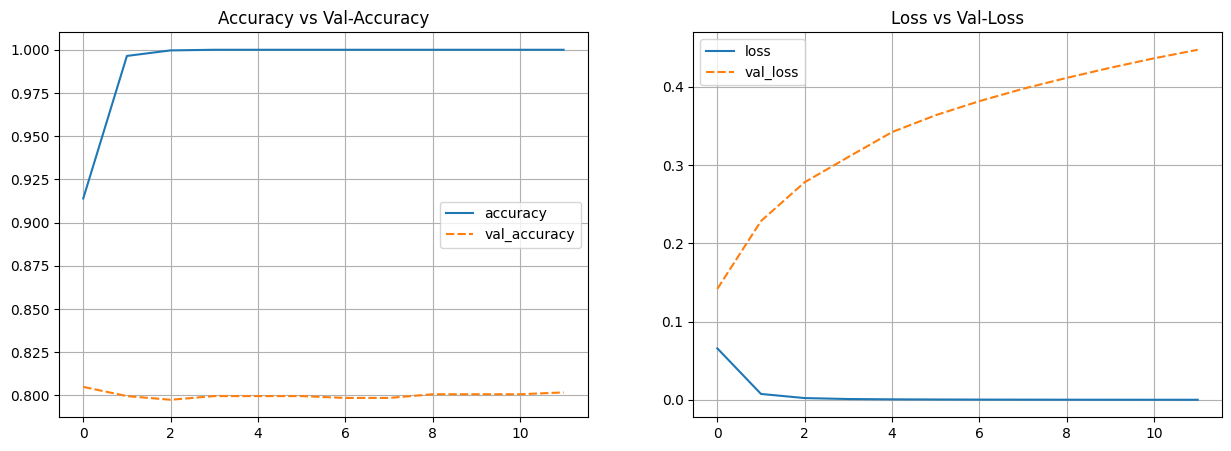

In [91]:
# Plot Training Results

history_model_1 = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_1[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### **6.3.2. GRU** 

- Our model is a quite overfitting to our train set, as we can see from the gap between train and val lines
- The model's accuracy stopped improving after epoch 2
- The model's loss got worse as the epoch progressed

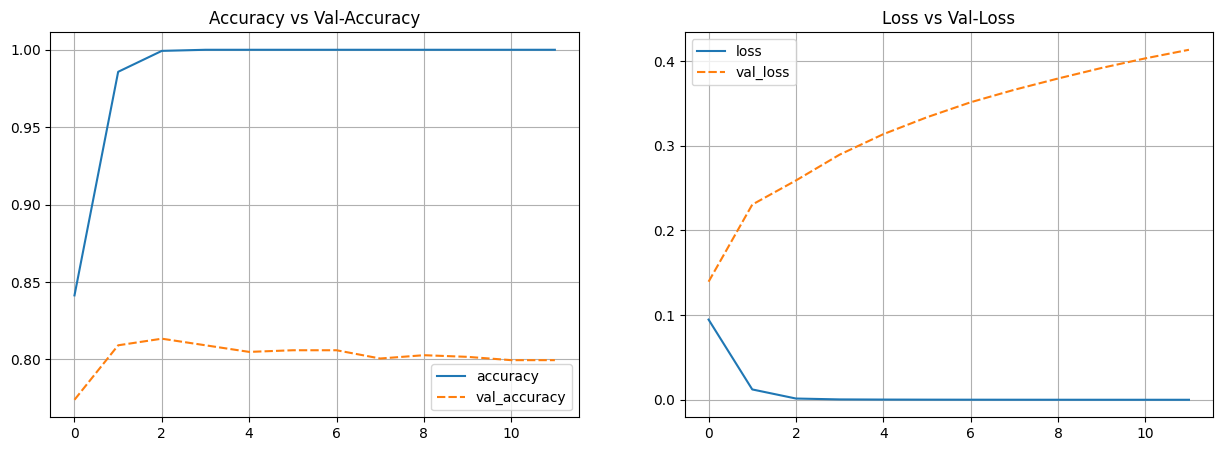

In [92]:
# Plot Training Results

history_model_2 = pd.DataFrame(model_gru_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_2[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_2[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### **6.3.3. Comparison**

- The model that we think is better out of the two is `LSTM` because it has slightly better weighted avg f1-score even
    - We observe the weighted avg f1-score because we think it's the best metric to represents the overall performance

In [93]:
# get predictions

y_test_pred_lstm_1 = model_lstm_1.predict(X_test_vect)
y_test_pred_gru_1 = model_gru_1.predict(X_test_vect)

40/40 [==============================] - 4s 73ms/step


In [94]:
# turn proba into label
threshold = 0.75

y_test_pred_lstm_1_label = np.where(y_test_pred_lstm_1 > threshold, 1, 0)
y_test_pred_gru_1_label = np.where(y_test_pred_gru_1 > threshold, 1, 0)

In [95]:
# function for getting classification report that returns df
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    # df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [96]:
# compare the 2 classification matrices
print('lstm:')
display(get_classification_report(y_test, y_test_pred_lstm_1_label))

print('gru:')
display(get_classification_report(y_test, y_test_pred_gru_1_label))

lstm:


,precision,recall,f1-score,support
0,0.731579,0.679707,0.704689,409.0000
1,0.849425,0.878716,0.863822,841.0000
accuracy,0.813600,0.813600,0.813600,0.8136
macro avg,0.790502,0.779211,0.784256,1250.0000
weighted avg,0.810866,0.813600,0.811754,1250.0000


gru:


,precision,recall,f1-score,support
0,0.686937,0.745721,0.715123,409.0000
1,0.870968,0.834721,0.852459,841.0000
accuracy,0.805600,0.805600,0.805600,0.8056
macro avg,0.778952,0.790221,0.783791,1250.0000
weighted avg,0.810753,0.805600,0.807523,1250.0000


# **7. ANN Improvement**

- The one that we'll improve upon is the model using `LSTM` because it has slightly better weighted avg f1-score even
    - We observe the weighted avg f1-score because we think it's the best metric to represents the overall performance

## **7.1. Model Definition**

- Some things that we added to our model are,
    - More layers
        - Giving our model more complexity, we hope this can help our model learn more and achieve better performance
    - More neurons
        - Giving our model more information to learn from, we hope this can help our model learn more and achieve better performance
    - Dropout
        - Removing some part of our features, we hope this can help our model to not get too overfitted
    - Adjusted learning rate (faster)
        - Increasing our learning rate, we hope this can help our model to not get too overfitted

In [104]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(embedding)
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(rate=0.25))
model_lstm_2.add(Bidirectional(LSTM(24, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(rate=0.15))
model_lstm_2.add(Dense(16, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_lstm_2.add(Dense(1, activation='sigmoid'))

model_lstm_2.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                    metrics='accuracy')

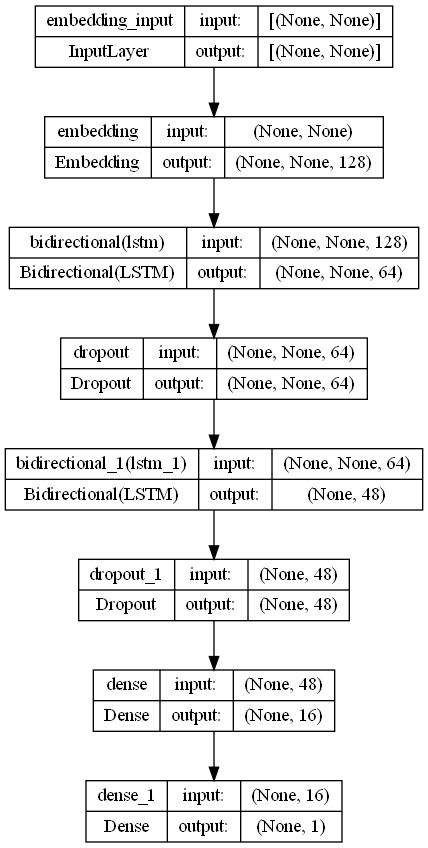

In [105]:
# plot layers
tf.keras.utils.plot_model(model_lstm_2, show_shapes=True)

## **7.2. Model Training**

In [106]:
model_lstm_2_hist = model_lstm_2.fit(X_train_vect, y_train, epochs=25, validation_data=(X_val_vect, y_val), callbacks=[early_stopping])

Epoch 1/25
88/88 [==============================] - 24s 233ms/step - loss: 0.0192 - accuracy: 0.9687 - val_loss: 0.3512 - val_accuracy: 0.7868
Epoch 2/25
88/88 [==============================] - 20s 222ms/step - loss: 0.0044 - accuracy: 0.9968 - val_loss: 0.3994 - val_accuracy: 0.8038
Epoch 3/25
88/88 [==============================] - 20s 222ms/step - loss: 0.0028 - accuracy: 0.9975 - val_loss: 0.3641 - val_accuracy: 0.8006
Epoch 4/25
88/88 [==============================] - 20s 222ms/step - loss: 0.0049 - accuracy: 0.9947 - val_loss: 0.5137 - val_accuracy: 0.7900
Epoch 5/25
88/88 [==============================] - 20s 223ms/step - loss: 0.0045 - accuracy: 0.9954 - val_loss: 0.4313 - val_accuracy: 0.7996
Epoch 6/25
88/88 [==============================] - 20s 223ms/step - loss: 8.2065e-05 - accuracy: 1.0000 - val_loss: 0.5494 - val_accuracy: 0.7974
Epoch 7/25
88/88 [==============================] - 20s 223ms/step - loss: 2.4572e-05 - accuracy: 1.0000 - val_loss: 0.5861 - val_accuracy

## **7.3. Model Evaluation**

### **7.3.1. Improvement**

- Our model after improvement is a quite overfitting to our train set, as we can see from the gap between train and val lines
- From the lack of change in our accuracy line between train and val sets, it looks like we're experiencing a bit of vanishing gradient towards the end of our epoch
- The model's loss got worse as the epoch progressed

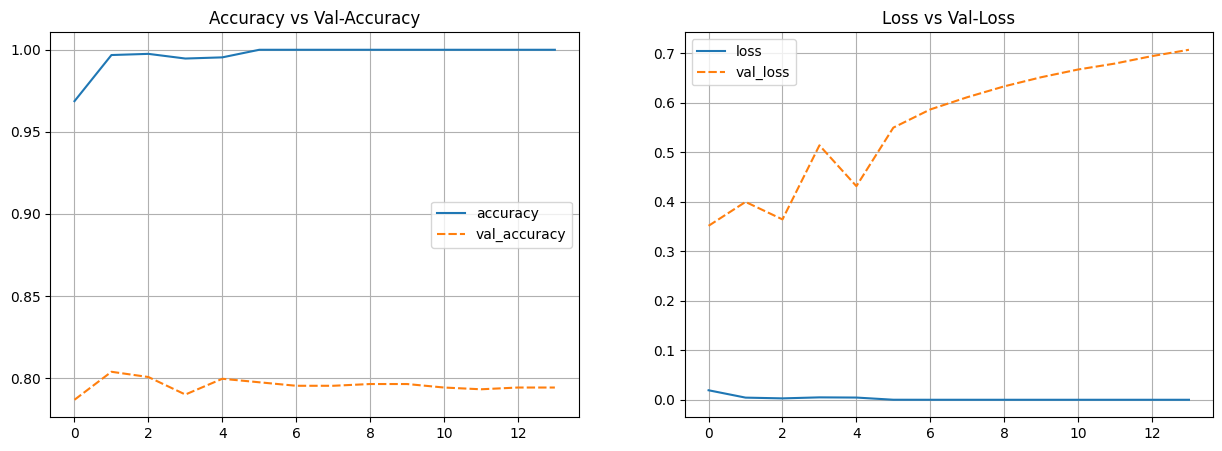

In [107]:
# Plot Training Results

history_model_3 = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_3[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_3[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### **7.3.2. Comparison**

- After going through improvement, there is a `slight improvement` to our `weighted avg f1-score`
    - We observe the weighted avg f1-score because we think it's the best metric to represents the overall performance

In [108]:
# get predictions

y_test_pred_lstm_2 = model_lstm_2.predict(X_test_vect)

40/40 [==============================] - 4s 84ms/step


In [109]:
# turn proba into label
threshold = 0.75

y_test_pred_lstm_2_label = np.where(y_test_pred_lstm_2 > threshold, 1, 0)

In [110]:
# compare the 2 classification matrices
print('lstm_before:')
display(get_classification_report(y_test, y_test_pred_lstm_1_label))

print('lstm_after:')
display(get_classification_report(y_test, y_test_pred_lstm_2_label))

lstm_before:


,precision,recall,f1-score,support
0,0.731579,0.679707,0.704689,409.0000
1,0.849425,0.878716,0.863822,841.0000
accuracy,0.813600,0.813600,0.813600,0.8136
macro avg,0.790502,0.779211,0.784256,1250.0000
weighted avg,0.810866,0.813600,0.811754,1250.0000


lstm_after:


,precision,recall,f1-score,support
0,0.729381,0.691932,0.710163,409.0000
1,0.853828,0.875149,0.864357,841.0000
accuracy,0.815200,0.815200,0.815200,0.8152
macro avg,0.791605,0.783540,0.787260,1250.0000
weighted avg,0.813109,0.815200,0.813905,1250.0000


# **8. Model Saving**

- We save our best model that we'll use for model inference and model deployment

In [112]:
pickle.dump({'config': text_vectorization.get_config(),
            'weights': text_vectorization.get_weights()}, 
            open("vectorizer.pkl", "wb"))

model_lstm_2.save("model.h5")

# **10. Conclussion**

## **10.1. EDA Insights Summary**

- Our data is quite imbalanced (32.7% not recommended and 67.3% recommended)
- The data distribution of user_review's word count is highly positively skewed (outliers on the right side)
- Some words that's associated with recomended user_suggestion that take up a lot of space in our wordcloud are 'game', 'NOPE', 'play', 'early', 'access'

## **10.2. Model Building Conclusion**

- Our base models can predict a review's sentiment (`user_suggestion`) using ANN model with `LSTM` and `GRU`, based on user_review
- We use `classification_report` as the metrics to evaluate our model to give us a better look at our models' false positive, false negative, and overall performance
- We observe the weighted avg f1-score because we think it's the best metric to represents the overall performance
- From the 2 base models that we've defined, trained, and evaluated, the model that we picked for further improvement was the one using `LSTM` layer which is the model with the better weighted avg f1-score,
- After going through improvement, there is a `slight improvement` to our `macro and weighted avg`,
- The models' comparison can be seen in tables below,

<center>

**base gru:**

|	|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.686937|0.745721|0.715123|409.0000|
|1|0.870968|0.834721|0.852459|841.0000|
|accuracy|0.805600|0.805600|0.805600|0.8056|
|macro avg|0.778952|0.790221|0.783791|1250.0000|
|weighted avg|0.810753|0.805600|0.807523|1250.0000|

**lstm before improvement:**

|	|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.731579|0.679707|0.704689|409.0000|
|1|0.849425|0.878716|0.863822|841.0000|
|accuracy|0.813600|0.813600|0.813600|0.8136|
|macro avg|0.790502|0.779211|0.784256|1250.0000|
|weighted avg|0.810866|0.813600|0.811754|1250.0000|

**lstm after improvement:**

|	|precision|recall|f1-score|support|
|---|---|---|---|---|
|0|0.729381|0.691932|0.710163|409.0000|
|1|0.853828|0.875149|0.864357|841.0000|
|accuracy|0.815200|0.815200|0.815200|0.8152|
|macro avg|0.791605|0.783540|0.787260|1250.0000|
|weighted avg|0.813109|0.815200|0.813905|1250.0000|

</center>

-   - As we can see from the table above, our best model, even after going through improvement performs `fairly well` in predicting review's sentiment (`user_suggestion`),
        - It is `overfitting` since there's a considerable gap between train and val lines
        - Our best model got weighted avg f1-score of `0.814`, which means that our features can explain `81.4% of the variance in our target`, and the rest can be explained by features outside of ours
    - Our model is able to output a review's sentiment (`user_suggestion`) with a completely unseen data, from the result of model inference  

## **10.3. Business Insight**

- There are more recommended reviews than not recommended reviews
- There seems to be an association between recommended games with the words 'game', 'NOPE', 'play', 'early', 'access'

## **10.4. Business Recommendation**

- To focus on increasing sales which can increase rating amount (looking at the recommended/not ratio, we assume more rating would result in better rating)
- To research what makes early access seems to be associated with recommended games
- To improve the model further

## **10.5. Room for Improvement**

- To use the whole data instead of just a sample of it
- To explore more avenues on model improvement
- To explore both LSTM and GRU models